### 2023-06-12 ML cloud profiles, CDFS, transects

Make figures describing the ML cloud predictions, both raw and thresholded

In [1]:
import contextlib
from string import ascii_lowercase
import xarray as xr
import numpy as np
import cftime
from dask.distributed import Client
from matplotlib import pyplot as plt
from cartopy import crs as ccrs 
from cycler import cycler
import fv3viz
import fv3fit
from fv3fit._shared import pack, PackerConfig
from vcm.catalog import catalog as CATALOG
from vcm.calc.histogram import histogram, histogram2d
from vcm.calc.thermo.vertically_dependent import mass_integrate
from vcm.select import meridional_ring
from vcm.interpolate import interpolate_unstructured, interpolate_to_pressure_levels

In [2]:
PREDICTIONS_PATHS = {
    "NN_seed_0": 'gs://vcm-ml-experiments/cloud-ml/2023-07-05/predicted-fine-cloud-fields-seed-0-squash-threshold-0.zarr',
    "NN_seed_0_squash_threshold_065": 'gs://vcm-ml-experiments/cloud-ml/2023-07-05/predicted-fine-cloud-fields-seed-0-squash-threshold-0.065.zarr',
}
NUDGED_COARSE_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run/state_after_timestep.zarr'
COARSENED_FINE_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-training-data.zarr'
PREDICTED_VARIABLES = [
    'cloud_amount',
    'cloud_water_mixing_ratio',
    'cloud_ice_mixing_ratio',
]
EVALUATION_VARIABLES = PREDICTED_VARIABLES + ['cloud_condensate_mixing_ratio']
HORIZONTAL_DIMS = ['x', 'y', 'tile', 'time']
TIME_SLICE = slice(
    cftime.DatetimeJulian(2020, 8, 7, 0, 30, 0),
    cftime.DatetimeJulian(2020, 8, 9, 23, 30, 0),
    4
) # hourly over days 8-10 validation
TIME_SNAPSHOT = cftime.DatetimeJulian(2020, 8, 7, 10, 30, 0, 0)
GRID = CATALOG['grid/c48'].read()
BIVARIATE_LEVEL = 63
QUANTILES = [0.25, 0.5, 0.75]
COLOR_CYCLE = [plt.rcParams['axes.prop_cycle'].by_key()['color'][i] for i in [0, 2, 1, 1]]
LINESTYLE_CYCLE = ['-', '-', '-', '-.']
LINEWIDTH_CYCLE = [1.5, 1, 1, 1]
plt.rcParams['font.size'] = 8
OUTDIR = 'figures'

In [3]:
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39339,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.39 GiB
Comm: tcp://127.0.0.1:36535,Total threads: 2
Dashboard: http://127.0.0.1:34415/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:43373,


In [4]:
def get_ds(path, var_names=PREDICTED_VARIABLES):
    ds = xr.open_zarr(path)
    return ds[var_names]

def get_delp(path, delp_name='pressure_thickness_of_atmospheric_layer'):
    ds = xr.open_zarr(path)
    return ds[delp_name]

def add_cloud_attrs(ds):
    for name, da in ds.items():
        if name == 'cloud_amount':
            da = da.assign_attrs({
                'long_name': 'fractional cloud cover',
                'units': '-'
            })
        elif name == 'cloud_ice_mixing_ratio':
            da = da.assign_attrs({
                'long_name': 'ice cloud mixing ratio',
                'units': 'kg/kg'
            })
        elif name == 'cloud_water_mixing_ratio':
            da = da.assign_attrs({
                'long_name': 'liquid cloud mixing ratio',
                'units': 'kg/kg'
            })
        ds[name] = da
    return ds

def get_cloud_condensate(cloud_ice_mixing_ratio, cloud_water_mixing_ratio):
    cloud_condensate_mixing_ratio = cloud_ice_mixing_ratio + cloud_water_mixing_ratio
    return cloud_condensate_mixing_ratio.assign_attrs({'long_name': 'total cloud mixing ratio', 'units': 'kg/kg'})

def interpolate_to_pressure_hpa(ds, delp):
    ds = interpolate_to_pressure_levels(ds, delp, dim='z')
    ds = ds.assign_coords({
        'pressure': (ds.pressure / 100).assign_attrs({
            'units': 'hPa'
        })
    })
    return ds
    
def add_column_integrated_vars(ds, delp):
    for var in ds.data_vars:
        if "mixing_ratio" in var:
            result = mass_integrate(ds[var], delp, dim='z')
            path_name = var.split('_mixing_ratio')[0].replace('_', ' ') + ' path'
            result = result.assign_attrs({'long_name': path_name, 'units': 'kg/m**2'})
        elif "amount" in var:
            result = ds[var].weighted(delp).mean(dim='z')
            result = result.assign_attrs({'long_name': 'column-averaged cloud amount', 'units': '-'})
        ds[f"column_integrated_{var}"] = result
    return ds

def area_weighted_mean(ds, dims=HORIZONTAL_DIMS):
    with xr.set_options(keep_attrs=True):
        return ds.weighted(GRID.area).mean(dim=dims)

def area_weighted_bias(error, dims=HORIZONTAL_DIMS):
    return area_weighted_mean(error, dims=dims)

def area_weighted_mse(x, y, dims=HORIZONTAL_DIMS):
    with xr.set_options(keep_attrs=True):
        squared_error = (x - y) ** 2
    return area_weighted_mean(squared_error, dims=dims)

def area_weighted_variance(ds, dims=HORIZONTAL_DIMS):
    mean = area_weighted_mean(ds, dims=dims)
    with xr.set_options(keep_attrs=True):
        variance = (ds - mean)**2
    return area_weighted_mean(variance, dims=dims)

def area_weighted_r_squared(mse, var):
    with xr.set_options(keep_attrs=True):
        return 1 - mse / var

def get_bins(*datasets, varnames, n_bins=100, alpha_lo=0.001, alpha_hi=0.001, small=0.0, large=1.0, scale='linear'):
    bin_edges, bin_centers = {}, {}
    for var_ in varnames:
        hi = np.mean([ds[var_].quantile(1 - alpha_hi) for ds in datasets])
        lo = np.mean([ds[var_].quantile(alpha_lo) for ds in datasets])
        if scale == 'linear':
            range_interior = np.linspace(lo, hi, n_bins - 2)
            range_exterior = np.concatenate(([small], range_interior, [large]))
        elif scale == 'log':
            range_interior = np.logspace(np.log10(lo + small), np.log10(hi), n_bins - 1)
            range_exterior = np.concatenate((range_interior, [large]))
        else:
            raise ValueError
        bin_edges[var_] = range_exterior
        centers = (range_exterior[1:] + range_exterior[:-1]) / 2
        centers[0] = 2*centers[1] - centers[2]
        centers[-1] = 2*centers[-2] - centers[-3]
        bin_centers[var_] = centers
    return bin_edges, bin_centers

def get_cdfs(da, minval=None, **hist_kwargs):
    if minval is not None:
        da = da.where(da > minval, minval)
    bins = hist_kwargs.get('bins', None)
    if bins is not None:
        counts, _ = histogram(da, **hist_kwargs)
    else:
        counts, bins = histogram(da, **hist_kwargs)
    cdf = (counts.cumsum() / da.size)
    return cdf

def conditional_quantiles(field, conditional, bin_edges, quantiles=QUANTILES):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    field_conditional = field.groupby_bins(conditional, bin_edges)
    field_quantiles = []
    for q in quantiles:
        field_quantiles.append(field_conditional.quantile(q))
    field_quantiles = xr.concat(field_quantiles, dim=xr.DataArray(quantiles, name='quantile', dims=['quantile']))
    return field_quantiles

def weighted_quantile(array, weights, dims, q):
    weighted_cumulative = (array * weights).cumsum(dim=dims)
    weighted_sum = (array * weights).sum(dim=dims)
    weighted_cumulative_normalized = (weighted_cumulative / weighted_sum).fillna(0.0)
    quantile_coords = np.abs(weighted_cumulative_normalized - q).argmin(dim=dims)
    return array.isel(quantile_coords), weighted_cumulative_normalized

def log_ds(ds, log_func=np.log10):
    log = xr.Dataset()
    for var in ds.data_vars:
        log[var] = log_func(ds[var]).assign_attrs({
            'long_name': f"log({ds[var].attrs.get('long_name', var)})",
            'units': f"log({ds[var].attrs.get('units', 'unknown')})",
        })
    return log

@contextlib.contextmanager
def modified_plot_cycle(ax, old_color_cycle=COLOR_CYCLE, old_linestyle_cycle=LINESTYLE_CYCLE, **kwargs):
    new_cycler = cycler(**{k: v for k, v in kwargs.items() if v is not None})
    ax.set_prop_cycle(new_cycler)
    yield
    ax.set_prop_cycle(cycler(color=old_color_cycle) + cycler(linestyle=old_linestyle_cycle))

In [5]:
prediction_datasets = {}
for name, path in PREDICTIONS_PATHS.items():
    print(name)
    ds = get_ds(path)
    prediction_datasets[name] = ds

print('coarsened fine')
coarsened_fine_ds = get_ds(COARSENED_FINE_PATH).sel(time=TIME_SLICE)

print('nudged coarse baseline')
baseline_ds = get_ds(NUDGED_COARSE_PATH).sel(time=TIME_SLICE)
delp = get_delp(NUDGED_COARSE_PATH).sel(time=TIME_SLICE)

NN_seed_0
NN_seed_0_squash_threshold_065
coarsened fine
nudged coarse baseline


In [6]:
datasets = []
for name, ds in zip(
    ["coarsened_fine", "baseline_coarse_nudged"] + list(prediction_datasets.keys()),
    [coarsened_fine_ds, baseline_ds] + list(prediction_datasets.values())
):
    ds = (
        ds
        .pipe(add_cloud_attrs)
        .where(ds > 0.0, 0.0) # there are small amounts of negative values in the coarsened fine dataset
        .assign(
            cloud_condensate_mixing_ratio=get_cloud_condensate(
                ds.cloud_ice_mixing_ratio,
                ds.cloud_water_mixing_ratio
            )
        )
        .pipe(add_column_integrated_vars, delp)
    )
    datasets.append(ds.expand_dims({'run': [name]}))
datasets = xr.concat(datasets, dim='run', join='inner')
datasets_pressure = interpolate_to_pressure_hpa(datasets.chunk(dict(z=-1)).drop_vars(['tile', 'x', 'y']), delp)

In [7]:
datasets_pressure.load()

<xarray.Dataset>
Dimensions:                                          (time: 72, run: 4, pressure: 35, tile: 6, y: 48, x: 48)
Coordinates:
  * time                                             (time) object 2020-08-07...
  * run                                              (run) <U30 'coarsened_fi...
  * pressure                                         (pressure) float64 3.0 ....
Dimensions without coordinates: tile, y, x
Data variables:
    cloud_amount                                     (time, tile, y, x, run, pressure) float64 ...
    cloud_water_mixing_ratio                         (time, tile, y, x, run, pressure) float64 ...
    cloud_ice_mixing_ratio                           (time, tile, y, x, run, pressure) float64 ...
    cloud_condensate_mixing_ratio                    (time, tile, y, x, run, pressure) float64 ...
    column_integrated_cloud_amount                   (run, time, tile, y, x) float64 ...
    column_integrated_cloud_water_mixing_ratio       (run, time, tile, y, x) float64 ...
    column_integrated_cloud_ice_mixing_ratio         (run, time, tile, y, x) float64 ...
    column_integrated_cloud_condensate_mixing_ratio  (run, time, tile, y, x) float64 ...

In [8]:
vertical_vars = [var for var in datasets_pressure.data_vars if 'pressure' in datasets_pressure[var].dims]
non_coarsened_fine_runs = [run.item() for run in datasets_pressure.run if run != 'coarsened_fine']

profiles = area_weighted_mean(datasets_pressure[vertical_vars])
mse = area_weighted_mse(
    datasets_pressure.sel(run=non_coarsened_fine_runs)[vertical_vars],
    datasets_pressure.sel(run='coarsened_fine')[vertical_vars]
)
coarsened_fine_variance = area_weighted_variance(datasets_pressure.sel(run='coarsened_fine')[vertical_vars])
r_squared = area_weighted_r_squared(mse, coarsened_fine_variance)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


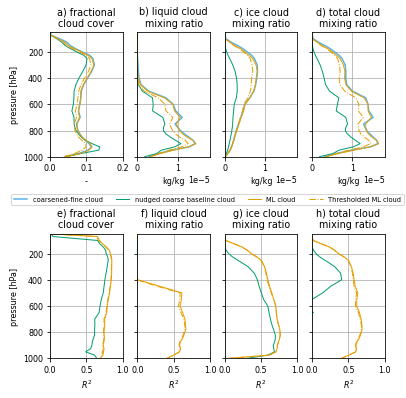

In [9]:
var_scale = [0.2, 1.8e-5, 1.8e-5, 1.8e-5]
fig, axes = plt.subplots(2, 4, sharex=False, sharey=True, gridspec_kw={'hspace': 0.62})
for i, (variable_name, profile_ax, r2_ax) in enumerate(zip(EVALUATION_VARIABLES, axes[0], axes[1])):
    with modified_plot_cycle(profile_ax, color=COLOR_CYCLE, linestyle=LINESTYLE_CYCLE, linewidth=LINEWIDTH_CYCLE):
        profiles[variable_name].plot(y='pressure', hue='run', yincrease=False, ax=profile_ax, add_legend=False)
    with modified_plot_cycle(r2_ax, color=COLOR_CYCLE[1:], linestyle=LINESTYLE_CYCLE[1:], linewidth=LINEWIDTH_CYCLE[1:]):
        r_squared[variable_name].plot(y='pressure', hue='run', yincrease=False, ax=r2_ax, add_legend=False)
    profile_ax.grid()
    profile_ax.set_xlim(0, var_scale[i])
    profile_ax.set_xlabel(profiles[variable_name].attrs['units'])
    profile_ax.set_ylim([1000, 50])
    profile_ax.set_title(
        f"{ascii_lowercase[i]}) " 
        + (
            profiles[variable_name]
            .attrs['long_name']
            .replace(' mixing', '\nmixing')
            .replace(' cloud cover', '\ncloud cover')
        )
    )
    r2_ax.grid()
    r2_ax.set_xlim([0, 1])
    r2_ax.set_xlabel(r'$R^2$')
    r2_ax.set_ylim([1000, 50])
    if i > 0:
        profile_ax.set_ylabel(None)
        r2_ax.set_ylabel(None)
    r2_ax.set_title(
        f"{ascii_lowercase[i + 4]}) " 
        + (
            r_squared[variable_name]
            .attrs['long_name']
            .replace(' mixing', '\nmixing')
            .replace(' cloud cover', '\ncloud cover')
        )
    )
fig.legend(
    ['coarsened-fine cloud', 'nudged coarse baseline cloud', 'ML cloud', 'Thresholded ML cloud'],
    loc='center', ncol=4, bbox_to_anchor=(0.48, 0.46), fontsize='small'
)
fig.set_size_inches([6, 6])
fig.savefig(f'./{OUTDIR}/ml_cloud_profiles.eps', bbox_inches='tight')

In [10]:
meridional_transect = meridional_ring(lon=60)

transect = interpolate_unstructured(
    xr.merge([datasets_pressure[EVALUATION_VARIABLES], GRID.lat, GRID.lon]), meridional_transect
).swap_dims({'sample': 'lat'})
for var in EVALUATION_VARIABLES:
    transect[var] = transect[var].assign_attrs(**datasets[var].attrs)
    
with xr.set_options(keep_attrs=True):
    transect_time_mean = transect.mean('time')

log_transect_time_mean = log_ds(transect_time_mean)

/home/brianh/miniconda3/envs/fv3net/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/brianh/miniconda3/envs/fv3net/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


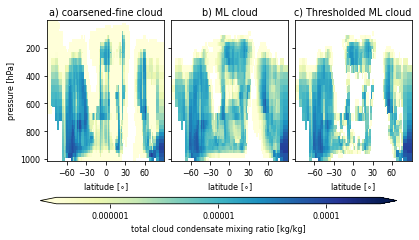

In [11]:
fg = (
    log_transect_time_mean
    .cloud_condensate_mixing_ratio
    .sel(run=['coarsened_fine', 'NN_seed_0', 'NN_seed_0_squash_threshold_065'])
    .plot(
        col='run',
        vmin=-6.5,
        vmax=-3.5,
        yincrease=False,
        cmap='YlGnBu',
        add_colorbar=False,
        rasterized=True
    )
)
fig = fg.fig
axes = fg.axes
[
    (
        ax.set_title(title),
        ax.set_xticks(np.arange(-60, 90, 30)),
        ax.set_xlabel('latitude $[\circ]$')
    )
    for ax, title in 
    zip(axes.flatten(), ['a) coarsened-fine cloud', 'b) ML cloud', 'c) Thresholded ML cloud'])
]
fig.subplots_adjust(bottom=0.25)
cax = fig.add_axes([0.05, 0.05, 0.9, 0.03])
cbar_ticks = np.linspace(-6, -4, 3)
cbar_ticklabels = [f"{10**i:{abs(int(i))}.{abs(int(i))}f}" for i in cbar_ticks]
cbar = plt.colorbar(
    fg._mappables[0],
    cax=cax,
    extend='both',
    label='total cloud condensate mixing ratio [kg/kg]',
    orientation='horizontal',
    ticks=cbar_ticks
)
cbar.ax.set_xticklabels(cbar_ticklabels)
fig.set_size_inches([5.5, 3])
fig.savefig(f'./{OUTDIR}/ml_cloud_transects.eps', bbox_inches='tight')

In [12]:
column_vars = [var for var in datasets.data_vars if 'z' not in datasets[var].dims]

bin_edges, _ = get_bins(
    datasets_pressure,
    varnames=EVALUATION_VARIABLES,
    n_bins=1000,
    small=-1.e-5,
)

bin_edges_log, _ = get_bins(
    datasets_pressure,
    varnames=EVALUATION_VARIABLES,
    n_bins=1000,
    scale='log', 
    small=1.e-10,
)

column_bin_edges_log, _ = get_bins(
    datasets_pressure,
    varnames=column_vars,
    scale='log',
    small=1e-10,
    large=5.0,
    n_bins=1000
)

In [13]:
cdfs = xr.Dataset()
cdfs_log = xr.Dataset()
for var in EVALUATION_VARIABLES:
    das, das_log = [], []
    for run in datasets.run:
        data = datasets.sel(run=run.item())[var].compute()
        das.append(get_cdfs(data, bins=bin_edges[var]))
        das_log.append(get_cdfs(data, bins=bin_edges_log[var], minval=1e-10))
    cdfs[var + '_CDF'] = xr.concat(das, dim=datasets.run)
    cdfs_log[var + '_CDF'] = xr.concat(das_log, dim=datasets.run)
column_cdfs_log = xr.Dataset()
for var in column_vars:
    column_das_log, column_das_quantile = [], []
    for run in datasets.run:
        data = datasets.sel(run=run.item())[var].compute()
        column_das_log.append(get_cdfs(data, bins=column_bin_edges_log[var], minval=1e-10))
    column_cdfs_log[var + '_CDF'] = xr.concat(column_das_log, dim=datasets.run)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


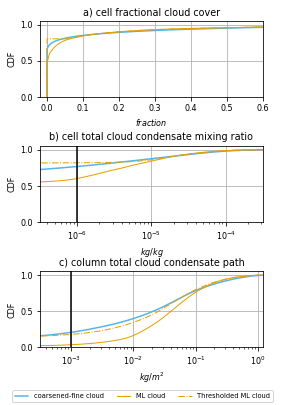

In [14]:
fig, axes = plt.subplots(3, 1, gridspec_kw=dict(hspace=0.65))
run_inds = [0, 2, 3]
ax0 = axes.flatten()[0]
with modified_plot_cycle(
    ax0,
    color=[COLOR_CYCLE[i] for i in run_inds],
    linestyle=[LINESTYLE_CYCLE[i] for i in run_inds],
    linewidth=[LINEWIDTH_CYCLE[i] for i in run_inds]
):
    h = cdfs['cloud_amount_CDF'].sel(run=['coarsened_fine', 'NN_seed_0', 'NN_seed_0_squash_threshold_065']).plot(hue='run', ax=ax0, add_legend=False)
ax0.set_xscale('linear')
ax0.set_xlim([-0.02, 0.6])
ax0.set_xlabel(r'$fraction$')
ax0.set_ylabel('CDF')
ax0.set_ylim([0., 1.05])
ax0.set_title('a) cell fractional cloud cover')
ax0.grid()
ax1 = axes.flatten()[1]
with modified_plot_cycle(
    ax1,
    color=[COLOR_CYCLE[i] for i in run_inds],
    linestyle=[LINESTYLE_CYCLE[i] for i in run_inds],
    linewidth=[LINEWIDTH_CYCLE[i] for i in run_inds]
):
    cdfs_log['cloud_condensate_mixing_ratio_CDF'].sel(run=['coarsened_fine', 'NN_seed_0', 'NN_seed_0_squash_threshold_065']).plot(hue='run', ax=ax1, add_legend=False)
ax1.plot([1e-6, 1e-6], [0, 1.05], 'k-')
ax1.set_xscale('log')
ax1.set_xlim([10**-6.5, 10**-3.5])
ax1.set_xlabel(r'$kg/kg$')
ax1.set_ylabel('CDF')
ax1.set_ylim([0., 1.05])
ax1.set_title('b) cell total cloud condensate mixing ratio')
ax1.grid()
ax2 = axes.flatten()[2]
with modified_plot_cycle(
    ax2,
    color=[COLOR_CYCLE[i] for i in run_inds],
    linestyle=[LINESTYLE_CYCLE[i] for i in run_inds],
    linewidth=[LINEWIDTH_CYCLE[i] for i in run_inds]
):
    column_cdfs_log['column_integrated_cloud_condensate_mixing_ratio_CDF'].sel(run=['coarsened_fine', 'NN_seed_0', 'NN_seed_0_squash_threshold_065']).plot(hue='run', ax=ax2, add_legend=False)
ax2.plot([1e-3, 1e-3], [0, 1.05], 'k-')
ax2.set_xscale('log')
ax2.set_xlim([10**-3.5, 1.2])
ax2.set_xlabel(r'$kg/{m^2}$')
ax2.set_ylabel('CDF')
ax2.set_ylim([0., 1.05])
ax2.set_title('c) column total cloud condensate path')
ax2.grid()
fig.legend(h, ['coarsened-fine cloud', 'ML cloud', 'Thresholded ML cloud'], ncol=3, loc='lower center', fontsize='small')
fig.set_size_inches([4, 6])
fig.savefig(f'./{OUTDIR}/ml_cloud_cdfs.eps', bbox_inches='tight')

In [15]:
# ! cat ~/dev/fv3net/external/fv3viz/fv3viz/_plot_cube.py

/home/brianh/miniconda3/envs/fv3net/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/brianh/miniconda3/envs/fv3net/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/brianh/miniconda3/envs/fv3net/lib/python3.8/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


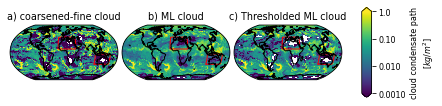

In [16]:
callouts = [ # (l, b), w, h
    [
        (-20, 10), 60, 35 # Sahara/Sahel
    ],
    [
        (105, -35), 50, 30 # Western Australia 
    ],
]

fig, axes, h, _, fg = fv3viz.plot_cube(
    xr.merge([
        np.log10(
            datasets_pressure
            .column_integrated_cloud_condensate_mixing_ratio
            .sel(time=TIME_SNAPSHOT, run=['coarsened_fine', 'NN_seed_0', 'NN_seed_0_squash_threshold_065'])
        ),
        GRID,
    ]),
    'column_integrated_cloud_condensate_mixing_ratio',
    col='run',
    vmin=-3,
    vmax=0,
    colorbar=None,
    rasterized=True
)
for ax, title in zip(axes.flatten(), ['a) coarsened-fine cloud', 'b) ML cloud', 'c) Thresholded ML cloud']):
    ax.set_title(title)
    for callout in callouts:
        p = plt.Rectangle(*callout, transform=ccrs.PlateCarree(), fill=False, color='r', lw=1)
        ax.add_patch(p)
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
cbar_ticks = np.linspace(-3, 0, 4)
cbar_ticklabels = [f"{10**tick:{abs(int(tick))}.{abs(int(tick)) + 1}f}" for tick in cbar_ticks]
cbar = plt.colorbar(
    h[0],
    cax=cax,
    extend="both",
    label='cloud condensate path\n' + r'[$kg/{m^2}$]',
    ticks=cbar_ticks
)
cbar.ax.set_yticklabels(cbar_ticklabels)
fig.set_size_inches([5.5, 2.5])
fig.savefig(f'./{OUTDIR}/ml_cloud_condensate_path_maps.pdf', bbox_inches='tight')

In [17]:
bivariate_bin_edges, _ = get_bins(
    datasets_pressure,
    varnames=['cloud_condensate_mixing_ratio', 'cloud_amount'],
    n_bins=50,
    small=-1e-10
)

das = []
for name, ds in zip(
    ['coarsened_fine', 'NN_seed_0'],
    [datasets.sel(run='coarsened_fine', z=BIVARIATE_LEVEL), datasets.sel(run='NN_seed_0', z=BIVARIATE_LEVEL)]
):
    counts, _, _ = histogram2d(
        ds['cloud_condensate_mixing_ratio'],
        ds['cloud_amount'],
        bins=(bivariate_bin_edges['cloud_condensate_mixing_ratio'], bivariate_bin_edges['cloud_amount'])
    )
    das.append((counts / ds['cloud_condensate_mixing_ratio'].size).expand_dims({'run': [name]}))
bivariate_dist = xr.concat(das, dim='run')
rename = {}
for coord in list(bivariate_dist.coords):
    if coord.endswith('_bins'):
        rename[coord] = coord[:-5]
bivariate_dist = bivariate_dist.rename(rename)
bivariate_dist.coords['cloud_amount'].attrs = {'long_name': 'cloud amount', 'units': 'fraction'}
bivariate_dist.coords['cloud_condensate_mixing_ratio'].attrs = {'long_name': 'cloud_condensate_mixing_ratio'.replace('_', ' '), 'units': 'kg/kg'}

In [18]:
q_das = []
QUANTILES_05 = [0.05, 0.50, 0.95]
for q in QUANTILES_05:
    quantile, _ = weighted_quantile(
            bivariate_dist['cloud_condensate_mixing_ratio'],
            bivariate_dist,
            dims=['cloud_condensate_mixing_ratio',],
            q=q
        )
    q_das.append(quantile.drop_vars(['cloud_condensate_mixing_ratio']).expand_dims({'quantiles': [f"q={q:0.2f}"]}))
bivariate_quantiles = xr.concat(q_das, dim='quantiles')

In [19]:
condensate_bins = [(0, 5e-6), (5e-5, 6e-5)]
amount_bins = [(0, 0.02), (0.3, 0.32)]

n_samples = 100

condensate_coarsened_fine = datasets['cloud_condensate_mixing_ratio'].sel(run='coarsened_fine', z=BIVARIATE_LEVEL)
amount_coarsened_fine = datasets['cloud_amount'].sel(run='coarsened_fine', z=BIVARIATE_LEVEL)

subsamples = []
for condensate_bin, amount_bin in zip(condensate_bins, amount_bins):
    box_coarsened_fine = (
        (condensate_coarsened_fine > condensate_bin[0]) 
        & (condensate_coarsened_fine < condensate_bin[1])
        & (amount_coarsened_fine > amount_bin[0])
        & (amount_coarsened_fine < amount_bin[1])
    )

    sample = (
        datasets
        .sel(run='NN_seed_0', z=BIVARIATE_LEVEL)
        [['cloud_condensate_mixing_ratio', 'cloud_amount']]
        .where(box_coarsened_fine)
        .stack({'cell': ['time', 'tile', 'y', 'x']})
        .dropna('cell')
    )

    subsample = (
        sample
        .isel(
            cell=np.random.choice(
                sample.sizes['cell'],
                size=n_samples,
                replace=False
            )
        )
    )
    subsample.load()
    subsamples.append(subsample)

/home/brianh/miniconda3/envs/fv3net/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/brianh/miniconda3/envs/fv3net/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


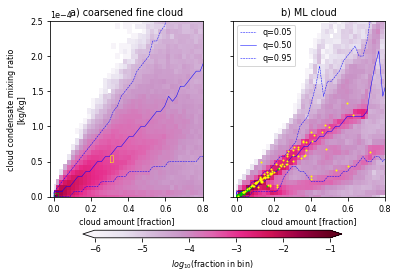

In [20]:
fig, axes = plt.subplots(1, 2)
ax0 = axes.flatten()[0]
ax0.set_prop_cycle(cycler(lw=[1, 1.5, 1]) + cycler(ls=['--', '-', '--']))
h = np.log10(bivariate_dist.sel(run='coarsened_fine')).plot(
    ax=ax0,
    cmap='PuRd',
    add_colorbar=False,
    vmin=-6,
    vmax=-1,
    rasterized=True
)
hq = bivariate_quantiles.sel(run='coarsened_fine').plot(
    hue='quantiles',
    ax=ax0,
    color='b',
    add_legend=False,
    lw=0.5
)
condensate_bin, amount_bin = condensate_bins[0], amount_bins[0]
ax0.plot(
    [
        amount_bin[0], amount_bin[1], amount_bin[1], amount_bin[0], amount_bin[0]
    ],
    [
        condensate_bin[0], condensate_bin[0], condensate_bin[1], condensate_bin[1], condensate_bin[0]
    ],
    '-',
    color=[0, 0.75, 0],
    lw=0.5
)
condensate_bin, amount_bin = condensate_bins[1], amount_bins[1]
ax0.plot(
    [
        amount_bin[0], amount_bin[1], amount_bin[1], amount_bin[0], amount_bin[0]
    ],
    [
        condensate_bin[0], condensate_bin[0], condensate_bin[1], condensate_bin[1], condensate_bin[0]
    ],
    '-',
    color=[1, 1, 0],
    lw=0.5
)
ax0.set_title('a) coarsened fine cloud')
ax0.set_xlim([-0.02, 0.8])
ax0.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax0.set_ylim([-1e-6, 2.5e-4])
ax1 = axes.flatten()[1]
ax1.set_prop_cycle(cycler(lw=[1, 1.5, 1]) + cycler(ls=['--', '-', '--']))
np.log10(bivariate_dist.sel(run='NN_seed_0')).plot(
    ax=ax1,
    cmap='PuRd',
    add_colorbar=False,
    vmin=-6,
    vmax=-1,
    rasterized=True
)
hq = bivariate_quantiles.sel(run='NN_seed_0').plot(
    hue='quantiles',
    ax=ax1,
    color='b',
    add_legend=False,
    lw=0.5
)
ax1.plot(
    subsamples[0].cloud_amount,
    subsamples[0].cloud_condensate_mixing_ratio,
    '.',
    color=[0, 0.75, 0],
    markersize=2,
)
ax1.plot(
    subsamples[1].cloud_amount,
    subsamples[1].cloud_condensate_mixing_ratio,
    '.',
    color=[1, 1, 0],
    markersize=2,
)
ax1.set_title('b) ML cloud')
ax1.set_xlim([-0.02, 0.8])
ax1.set_ylabel(None)
ax1.set_yticklabels([])
ax1.set_ylim([-1e-6, 2.5e-4])
ax1.legend(hq, [f"q={q:0.2f}" for q in QUANTILES_05])
fig.subplots_adjust(bottom=0.18)
cb_ax = fig.add_axes([0.2, 0.02, 0.6, 0.03])
cbar = plt.colorbar(
    h,
    cax=cb_ax,
    extend="both",
    orientation='horizontal',
    label=r'$log_{10}$(fraction in bin)',
)
fig.set_size_inches([6, 3.5])
fig.savefig(f'./{OUTDIR}/ml_cloud_amount_condensate_joint.eps', bbox_inches='tight')